In [1]:
import os
import pandas as pd
import xml.etree.ElementTree as ET
from nltk.corpus.reader import SemcorCorpusReader
from nltk.corpus import wordnet as wn
from transformers import AutoTokenizer, AutoModel
import numpy as np
import tqdm 
import nltk
import torch
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel

# nltk.download('wordnet')

# Data Visualization and Creating DataClass

In [2]:
nltk.data.find('corpora/semcor')

FileSystemPathPointer('/home2/arjun.dosajh/nltk_data/corpora/semcor')

In [3]:
semcor_root = '/home2/arjun.dosajh/nltk_data/corpora/semcor'
semcor_reader = SemcorCorpusReader(semcor_root, '.*', nltk.corpus.reader.wordnet)

In [4]:
tagged_sents = semcor_reader.tagged_sents(tag='both')

In [5]:
tagged_sents[0]

[Tree('DT', ['The']),
 Tree('group.n.01', [Tree('NE', [Tree('NNP', ['Fulton', 'County', 'Grand', 'Jury'])])]),
 Tree('say.v.01', [Tree('VB', ['said'])]),
 Tree('friday.n.01', [Tree('NN', ['Friday'])]),
 Tree('DT', ['an']),
 Tree('investigation.n.01', [Tree('NN', ['investigation'])]),
 Tree('IN', ['of']),
 Tree('atlanta.n.01', [Tree('NN', ['Atlanta'])]),
 Tree('POS', ["'s"]),
 Tree('recent.s.02', [Tree('JJ', ['recent'])]),
 Tree('primary_election.n.01', [Tree('NN', ['primary', 'election'])]),
 Tree('produce.v.04', [Tree('VB', ['produced'])]),
 Tree(None, ['``']),
 Tree('DT', ['no']),
 Tree('evidence.n.01', [Tree('NN', ['evidence'])]),
 Tree(None, ["''"]),
 Tree('IN', ['that']),
 Tree('DT', ['any']),
 Tree('irregularity.n.01', [Tree('NN', ['irregularities'])]),
 Tree('take_place.v.01', [Tree('VB', ['took', 'place'])]),
 Tree(None, ['.'])]

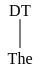

In [6]:
sample_tree = tagged_sents[0]

sample_tree[0]

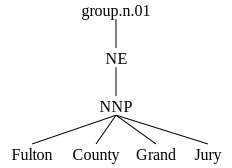

In [7]:
sample_tree[1]

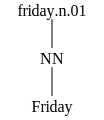

In [8]:
sample_tree[3]

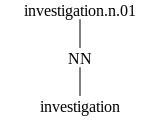

In [9]:
sample_tree[5]

In [10]:
def read_semcor_data(tagged_sents):
    """
    Read SemCor data from tagged sentences and return a pandas DataFrame
    """
    data = []
    for sent_idx, sentence in enumerate(tagged_sents):
        context_pos_sent = []
        context_sent = []
        for chunk in sentence:
            if isinstance(chunk, nltk.Tree):
                if chunk.label() == 'NE':  # Named Entity
                    word = ' '.join([w for w in chunk.leaves()])
                    pos = chunk.pos()[0][1]
                    synset_full = 'NE'
                else:
                    word = chunk.leaves()[0]
                    pos = chunk.label().split('.')[0] if chunk.label() else 'None'  # Extract POS from label
                    synset_full = chunk.label() if chunk.label() and '.' in chunk.label() else None  # Extract synset if available
                context_pos_sent.append(word + '_' + pos)
                context_sent.append(word)
            else:
                context_pos_sent.append(chunk[0] + '_' + (chunk[1] if chunk[1] else 'None'))  # Handle None labels
                context_sent.append(chunk[0])

        context_pos = ' '.join(context_pos_sent)
        context = ' '.join(context_sent)

        for chunk in sentence:
            if isinstance(chunk, nltk.Tree):
                if chunk.label() == 'NE':  # Named Entity
                    target_word = ' '.join([w for w in chunk.leaves()])
                    pos = chunk.pos()[0][1]
                    wn_index = None
                    synset_full = 'NE'
                else:
                    target_word = chunk.leaves()[0]
                    pos = chunk.label().split('.')[0] if chunk.label() else 'None'  # Extract POS from label
                    synset_full = chunk.label() if chunk.label() and '.' in chunk.label() else None  # Extract synset if available
                    wn_index = target_word + "%" + pos if synset_full else None
            else:
                target_word = chunk[0]
                pos = chunk[1] if chunk[1] else 'None'  # Handle None labels
                wn_index = None
                synset_full = None

            gloss = ""
            is_proper_gloss = False
            if synset_full is not None and synset_full != 'NE':
                for sense in wn.synsets(target_word):
                    if sense.name() == synset_full:
                        gloss = sense.definition()
                        is_proper_gloss = True
                        break

            data.append({
                "sentence_idx": sent_idx,
                "context": context,
                "context_pos": context_pos,
                "target_word": target_word,
                "pos": pos,
                "gloss": gloss,
                "is_proper_gloss": is_proper_gloss,
                "wn_index": wn_index,
                "sense_full": synset_full,
            })

    return pd.DataFrame(data)

In [11]:
df = read_semcor_data(tagged_sents)

In [12]:
df

,sentence_idx,context,context_pos,target_word,pos,gloss,is_proper_gloss,wn_index,sense_full
0,0,The Fulton said Friday an investigation of Atl...,The_DT Fulton_group said_say Friday_friday an_...,The,DT,,False,None,None
1,0,The Fulton said Friday an investigation of Atl...,The_DT Fulton_group said_say Friday_friday an_...,Fulton,group,,False,Fulton%group,group.n.01
2,0,The Fulton said Friday an investigation of Atl...,The_DT Fulton_group said_say Friday_friday an_...,said,say,,False,said%say,say.v.01
3,0,The Fulton said Friday an investigation of Atl...,The_DT Fulton_group said_say Friday_friday an_...,Friday,friday,the sixth day of the week; the fifth working day,True,Friday%friday,friday.n.01
4,0,The Fulton said Friday an investigation of Atl...,The_DT Fulton_group said_say Friday_friday an_...,an,DT,,False,None,None
...,...,...,...,...,...,...,...,...,...
778582,37175,`` I can n't turn the studio into a gambling o...,``_None I_PRP can_MD n't_RB turn_turn_into the...,'',None,,False,None,None
778583,37175,`` I can n't turn the studio into a gambling o...,``_None I_PRP can_MD n't_RB turn_turn_into the...,",",None,,False,None,None
778584,37175,`` I can n't turn the studio into a gambling o...,``_None I_PRP can_MD n't_RB turn_turn_into the...,I,PRP,,False,None,None
778585,37175,`` I can n't turn the studio into a gambling o...,``_None I_PRP can_MD n't_RB turn_turn_into the...,said,say,,False,said%say,say.v.01


In [13]:
df.iloc[0]

sentence_idx                                                       0
context            The Fulton said Friday an investigation of Atl...
context_pos        The_DT Fulton_group said_say Friday_friday an_...
target_word                                                      The
pos                                                               DT
gloss                                                               
is_proper_gloss                                                False
wn_index                                                        None
sense_full                                                      None
Name: 0, dtype: object

In [14]:
df[df['is_proper_gloss'] == True]

,sentence_idx,context,context_pos,target_word,pos,gloss,is_proper_gloss,wn_index,sense_full
3,0,The Fulton said Friday an investigation of Atl...,The_DT Fulton_group said_say Friday_friday an_...,Friday,friday,the sixth day of the week; the fifth working day,True,Friday%friday,friday.n.01
7,0,The Fulton said Friday an investigation of Atl...,The_DT Fulton_group said_say Friday_friday an_...,Atlanta,atlanta,state capital and largest city of Georgia; chi...,True,Atlanta%atlanta,atlanta.n.01
11,0,The Fulton said Friday an investigation of Atl...,The_DT Fulton_group said_say Friday_friday an_...,produced,produce,bring out for display,True,produced%produce,produce.v.04
14,0,The Fulton said Friday an investigation of Atl...,The_DT Fulton_group said_say Friday_friday an_...,evidence,evidence,your basis for belief or disbelief; knowledge ...,True,evidence%evidence,evidence.n.01
22,1,The jury further said in term end presentments...,The_DT jury_jury further_far said_say in_IN te...,jury,jury,a body of citizens sworn to give a true verdic...,True,jury%jury,jury.n.01
...,...,...,...,...,...,...,...,...,...
778522,37171,`` If I could only think something at the stud...,``_None If_IN I_PRP could_MD only_RB think_thi...,absorb,absorb,"take in, also metaphorically",True,absorb%absorb,absorb.v.04
778533,37172,`` What is Letch interested in '' ?,``_None What_WP is_be Letch_NNP interested_JJ ...,is,be,"have the quality of being; (copula, used with ...",True,is%be,be.v.01
778558,37174,"Her reply stung me , but this was too importan...","Her_PRP$ reply_NN stung_sting me_PRP ,_None bu...",was,be,"have the quality of being; (copula, used with ...",True,was%be,be.v.01
778562,37174,"Her reply stung me , but this was too importan...","Her_PRP$ reply_NN stung_sting me_PRP ,_None bu...",let,let,make it possible through a specific action or ...,True,let%let,let.v.01


In [32]:
lemmatizer = nltk.stem.WordNetLemmatizer()

def preprocess_semcor_data(dataset):
    cnt = 0
    data = dataset.copy()
    
    for i, row in tqdm.tqdm(dataset.iterrows(), total=len(dataset)):
        context_words = nltk.word_tokenize(row["context"])
        context_pos_words = nltk.word_tokenize(row["context_pos"])
        
        if row["wn_index"] is not None:
            target_word_lemma = row["wn_index"].split("%")[0]
            synsets = wn.synsets(target_word_lemma)
        else:
            target_word_lemma = None
            synsets = []
        
        # trg_idx = int(row['target_word'][1:])
        # trg_idx is the index of context at which target word is present
        # print(row['context'])
        if row['target_word'] not in context_words:
            continue
        else:
            trg_idx = context_words.index(row['target_word'])
            target_word = 'w' + str(trg_idx)
            row['target_word'] = target_word
            df.loc[i, 'target_word'] = target_word
            
        
        
        if len(synsets) > 0:
            target_synset = synsets[0]
        else:
            target_synset = None
        
        window_start = max(0, trg_idx - 10)
        window_end = min(len(context_words), trg_idx + 10)
        context_window = context_words[window_start:trg_idx] + context_words[trg_idx+1:window_end]
        context_window_pos = context_pos_words[window_start:trg_idx] + context_pos_words[trg_idx+1:window_end]
        
        if len(context_window) == 0:
            cnt = cnt + 1
        
        data.at[i, 'context'] = ' '.join(context_window)
        data.at[i, 'context_pos'] = ' '.join(context_window_pos)
    
    data = data[data["gloss"]!=""]
    data = data[data["context_pos"]!=""]
    data = data[data["context"]!=""]
    
    print("Number of proper glosses: ", data["is_proper_gloss"].sum())
    print(cnt)
    
    return data

In [33]:
dataset = preprocess_semcor_data(df[:50000])

  0%|          | 0/50000 [00:00<?, ?it/s]

100%|██████████| 50000/50000 [07:47<00:00, 107.05it/s]

Number of proper glosses:  15260
1


In [34]:
dataset

,sentence_idx,context,context_pos,target_word,pos,gloss,is_proper_gloss,wn_index,sense_full
3,0,The Fulton said Friday an investigation of Atl...,The_DT Fulton_group said_say Friday_friday an_...,w3,friday,the sixth day of the week; the fifth working day,True,Friday%friday,friday.n.01
7,0,The Fulton said Friday an investigation of Atl...,The_DT Fulton_group said_say Friday_friday an_...,w7,atlanta,state capital and largest city of Georgia; chi...,True,Atlanta%atlanta,atlanta.n.01
11,0,The Fulton said Friday an investigation of Atl...,The_DT Fulton_group said_say Friday_friday an_...,w11,produce,bring out for display,True,produced%produce,produce.v.04
14,0,The Fulton said Friday an investigation of Atl...,The_DT Fulton_group said_say Friday_friday an_...,w14,evidence,your basis for belief or disbelief; knowledge ...,True,evidence%evidence,evidence.n.01
22,1,The jury further said in term end presentments...,The_DT jury_jury further_far said_say in_IN te...,w1,jury,a body of citizens sworn to give a true verdic...,True,jury%jury,jury.n.01
...,...,...,...,...,...,...,...,...,...
49983,2198,neon superimposed on a rectangular base - to t...,neon_neon_tube superimposed_superimpose on_IN ...,diseased,diseased,caused by or altered by or manifesting disease...,True,diseased%diseased,diseased.s.01
49988,2198,base - to the supposedly diseased portions of ...,base_base -_None to_TO the_DT supposedly_suppo...,body,body,the entire structure of an organism (an animal...,True,body%body,body.n.01
49993,2198,"diseased portions of Mrs. 's body , Lee kept a...",diseased_diseased portions_portion of_IN Mrs._...,steady,steady,not subject to change or variation especially ...,True,steady%steady,steady.a.01
49996,2198,"Mrs. 's body , Lee kept a steady stream of sci...","Mrs._person 's_POS body_body , _None Lee_perso...",pseudo,pseudo,(often used in combination) not genuine but ha...,True,pseudo%pseudo,pseudo.s.01


In [36]:
dataset = dataset[dataset["sense_full"]!=""]

In [37]:
dataset.head(20)

,sentence_idx,context,context_pos,target_word,pos,gloss,is_proper_gloss,wn_index,sense_full
3,0,The Fulton said Friday an investigation of Atl...,The_DT Fulton_group said_say Friday_friday an_...,w3,friday,the sixth day of the week; the fifth working day,True,Friday%friday,friday.n.01
7,0,The Fulton said Friday an investigation of Atl...,The_DT Fulton_group said_say Friday_friday an_...,w7,atlanta,state capital and largest city of Georgia; chi...,True,Atlanta%atlanta,atlanta.n.01
11,0,The Fulton said Friday an investigation of Atl...,The_DT Fulton_group said_say Friday_friday an_...,w11,produce,bring out for display,True,produced%produce,produce.v.04
14,0,The Fulton said Friday an investigation of Atl...,The_DT Fulton_group said_say Friday_friday an_...,w14,evidence,your basis for belief or disbelief; knowledge ...,True,evidence%evidence,evidence.n.01
22,1,The jury further said in term end presentments...,The_DT jury_jury further_far said_say in_IN te...,w1,jury,a body of citizens sworn to give a true verdic...,True,jury%jury,jury.n.01
23,1,The jury further said in term end presentments...,The_DT jury_jury further_far said_say in_IN te...,w2,far,at or to or from a great distance in space,True,further%far,far.r.02
26,1,The jury further said in term end presentments...,The_DT jury_jury further_far said_say in_IN te...,w5,term,a limited period of time,True,term%term,term.n.02
27,1,The jury further said in term end presentments...,The_DT jury_jury further_far said_say in_IN te...,w6,end,the point in time at which something ends,True,end%end,end.n.02
28,1,The jury further said in term end presentments...,The_DT jury_jury further_far said_say in_IN te...,w7,presentment,an accusation of crime made by a grand jury on...,True,presentments%presentment,presentment.n.01
39,1,The jury further said in term end presentments...,The_DT jury_jury further_far said_say in_IN te...,w18,election,a vote to select the winner of a position or p...,True,election%election,election.n.01


In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [39]:
dataset = pd.read_csv("semcor_prepared.csv")

In [40]:
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=42)

In [41]:
max_len = 20

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased").to(device)

def create_embeddings(sentences, tokenizer, model, max_length, batch_size=32):
    embeddings = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    for i in range(0, len(sentences), batch_size):
        batch_sentences = sentences[i:i+batch_size]

        input_ids = []
        attention_masks = []

        # Tokenize each sentence and add special tokens for BERT
        for sentence in batch_sentences:
            encoded_dict = tokenizer.encode_plus(
                sentence,
                add_special_tokens=True,
                max_length=max_length,
                pad_to_max_length=True,
                return_attention_mask=True,
                return_tensors='pt'
            )

            input_ids.append(encoded_dict['input_ids'])
            attention_masks.append(encoded_dict['attention_mask'])

        # Convert the tokenized input into torch tensors
        input_ids = torch.cat(input_ids, dim=0).to(device)
        attention_masks = torch.cat(attention_masks, dim=0).to(device)

        # Feed the input to BERT and get the embeddings
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_masks)
            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(batch_embeddings)

    embeddings = np.concatenate(embeddings, axis=0)
    return embeddings

embeddings = create_embeddings(
    X_train['context'], tokenizer, model, max_len)
np.save('knn_bert4.npy', embeddings)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home2/arjun.dosajh/miniconda3/envs/pytorch/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [42]:
print(embeddings.shape)

(12208, 768)


In [43]:
test_embeddings = create_embeddings(
    X_test['context'], tokenizer, model, max_len)

/home2/arjun.dosajh/miniconda3/envs/pytorch/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [44]:
XTrain = pd.DataFrame(columns=['file', 'context', 'target_word', 'gloss', 'is_proper_gloss','wn_index'])
XTest = pd.DataFrame(columns=['file', 'context', 'target_word', 'gloss', 'is_proper_gloss','wn_index'])

XTrain = pd.concat([XTrain, X_train], ignore_index=True)
XTest = pd.concat([XTest, X_test], ignore_index=True)

XTrain.head(10)

cosine_similarities = []
zero_cos = 0

for i,test_embedding in enumerate(test_embeddings):
    test_target_word = XTest.iloc[i]['wn_index']
    train_rows = XTrain[XTrain['wn_index'] == test_target_word ]
    for j,train_row in train_rows.iterrows():
        train_embedding = embeddings[j]
        similarity = np.dot(test_embedding, train_embedding) / (np.linalg.norm(test_embedding) * np.linalg.norm(train_embedding))
        cosine_similarities.append(similarity)
    if len(cosine_similarities) == 0:
        zero_cos += 1
    if len(cosine_similarities) > 0 :
        # without using loc
        XTest.at[i, 'cosine_similarity'] = max(cosine_similarities)
    else:
        # X_test.loc[X_test.index[i], 'cosine_similarity'] = -1
        XTest.at[i, 'cosine_similarity'] = -1
    cosine_similarities = []


XTest['correct'] = XTest.apply(lambda row: row['gloss'] in XTrain[XTrain['wn_index']
                                 == row['wn_index']].head(10)['gloss'].tolist(), axis=1)

# # print the top-5 glosses of X_train for every X_test row 
X_test['top_5_glosses'] = X_test.apply(lambda row: X_train[X_train['wn_index'] == row['wn_index']].head(5)['gloss'].tolist(), axis=1)

### Accuracy of KNN

In [45]:
accuracy = XTest['correct'].sum() / len(XTest)
print("Accuracy: ", accuracy*100)
X_test.head(10)

Accuracy:  69.75753604193972


,sentence_idx,context,context_pos,target_word,pos,gloss,is_proper_gloss,wn_index,sense_full,top_5_glosses
14046,2061,of minimal information can result only in show...,of_IN minimal_minimal information_information ...,good,good,having desirable or positive qualities especia...,True,good%good,good.a.01,"[moral excellence or admirableness, having des..."
1035,147,Statements by other legislators that Dallas is...,Statements_statement by_IN other_other legisla...,w5,dallas,a large commercial and industrial city in nort...,True,Dallas%dallas,dallas.n.01,[a large commercial and industrial city in nor...
10508,1577,that sets him apart from all other bodybuilder...,that_IN sets_set him_PRP apart_apart from_IN a...,criterion,criterion,the ideal in terms of which something can be j...,True,criterion%criterion,criterion.n.02,[]
3954,656,a big night at bat with four hits in five incl...,a_DT big_big night_night at_NN bat_bat with_IN...,trips,trip,a journey for some purpose (usually including ...,True,trips%trip,trip.n.01,[]
7251,1201,"all been done in superb style , and the result...",all_DT been_VBN done_VB in_VB superb_superb st...,is,be,be identical to; be someone or something,True,is%be,be.v.02,"[have the quality of being; (copula, used with..."
251,39,"He will be succeeded by Ivan , who became a ca...",He_PRP will_MD be_VB succeeded_succeed by_IN I...,w18,announce,make known; make an announcement,True,announced%announce,announce.v.01,"[make known; make an announcement, make known;..."
511,69,Rep. of Commerce is asking the House in a priv...,Rep._person of_IN Commerce_group is_VBZ asking...,w16,support,the activity of providing for or maintaining b...,True,support%support,support.n.01,[the activity of providing for or maintaining ...
6277,1046,"business , which ( considering the talent at )...","main_main business_business , _None which_WDT ...",probably,probably,with considerable certainty; without much doubt,True,probably%probably,probably.r.01,[with considerable certainty; without much dou...
13932,2043,four year provision limits this to fundamental...,the_DT four_four year_year provision_provision...,material,material,the tangible substance that goes into the make...,True,material%material,material.n.01,[information (data or ideas or observations) t...
5678,936,"saying we announced its coming , not once but ...",saying_say we_PRP announced_announce its_PRP $...,times,time,an instance or single occasion for some event,True,times%time,time.n.01,[an instance or single occasion for some event...


# Naive Bayes

In [47]:
data = pd.read_csv("semcor_temp.csv")
print(len(data))
test_data = data[:500]
train_data = data[500:]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)

# Compute BERT embeddings for each sentence and target word
embeddings = []
for i, row in data.iterrows():
    context = row['context']
    context_pos = row['context_pos']
    # print(len(context_pos.split()))
    target_word = row['sense_full']
    gloss = row['gloss']
    tokens = tokenizer.encode(context, target_word, add_special_tokens=False)
    pos_tag_tokens = tokenizer.encode(context, add_special_tokens=False)
    # shuffle the pos_tag_tokens list
    np.random.shuffle(pos_tag_tokens)
    gloss_tokens = tokenizer.encode(gloss, add_special_tokens=False)
    tokens = tokens + [tokenizer.sep_token_id] + gloss_tokens 

    input_ids = torch.tensor(tokens).unsqueeze(0).to(device)
    pos_tag_ids = torch.tensor(pos_tag_tokens).unsqueeze(0).to(device)
    # Compute BERT embeddings
    with torch.no_grad():
        output = model(input_ids)
        context_embedding = output[0][0][1:-1].mean(dim=0).cpu()
        pos_embedding = model(pos_tag_ids)[0][0][1:-1].mean(dim=0).cpu()

    embedding = torch.cat([context_embedding, pos_embedding], dim=0).cpu().numpy()
    embeddings.append(embedding) 

15260
cuda:0


In [48]:
np.save('naive_bert_embeddings.npy', embeddings)

In [49]:
x_train = np.array(embeddings)
y_train = data['wn_index'].values

In [50]:
test_embeddings = embeddings[:500]
x_test = np.array(test_embeddings)

In [51]:
prior_probs = {}
likelihoods = {}
y_test = test_data['wn_index'].values

for sense in set(y_train):
    sense_count = sum(y_train == sense)
    # print(sense,sense_count)
    prior_probs[sense] = sense_count / len(y_train)   
    sense_embeddings = [x_train[i] for i in range(len(x_train)) if y_train[i] == sense]
    likelihoods[sense] = np.mean(sense_embeddings, axis=0)

In [53]:
y_pred = []

for i in tqdm(range(len(y_test)), desc="Predicting labels", total=len(y_test)):
    max_prob = 0
    max_sense = None

    for sense in set(y_train):
        log_prob = prior_probs[sense]

        for j in range(len(x_test[i])):
            log_prob = log_prob + x_test[i][j] * likelihoods[sense][j]

        if log_prob > max_prob:
            max_prob = log_prob
            max_sense = sense

    y_pred.append(max_sense)

correct = 0
for i in tqdm(range(len(y_test)), desc="Calculating accuracy", total=len(y_test)):
    if y_pred[i] == y_test.tolist()[i]:
        correct += 1

accuracy = correct / len(y_test)

Predicting labels:   0%|          | 0/500 [00:00<?, ?it/s]

Calculating accuracy: 100%|██████████| 500/500 [00:00<00:00, 289222.45it/s]


## Accuracy

In [54]:
print(accuracy*100)

22.400000000000002
